  UNIVERSITY LICENSE PLATE ACCESS CONTROL SYSTEM
loading Roboflow workspace...
loading Roboflow project...
  Dataset downloaded successfully
  Initializing Enhanced License Plate Detector...
  Using device: cuda


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Loading EasyOCR reader...
  Detector initialized successfully

  Authorized plates: {'51F31118', '51G1008', '60A03868', '61A22959'}

  Testing system with images...

  Testing Image 1/6
  ACCESS GRANTED - 60A03868 (EXACT_MATCH)
   Confidence: 0.75 (YOLO: 0.80, ViT: 0.58, OCR: 0.86)

  Testing Image 2/6
  ACCESS DENIED - 51651008 (Not Authorized)
   Confidence: 0.72 (YOLO: 0.84, ViT: 0.47, OCR: 0.86)

  Testing Image 3/6
  ACCESS GRANTED - E1F31118 (FUZZY_MATCH (51F31118))
   Confidence: 0.61 (YOLO: 0.80, ViT: 0.51, OCR: 0.54)

  Testing Image 4/6
  ACCESS DENIED - 61F78396 (Not Authorized)
   Confidence: 0.70 (YOLO: 0.80, ViT: 0.49, OCR: 0.81)

  Testing Image 5/6
  ACCESS GRANTED - 61A22959 (EXACT_MATCH)
   Confidence: 0.75 (YOLO: 0.80, ViT: 0.60, OCR: 0.85)

  Testing Image 6/6
  ACCESS DENIED - R2908NC (Not Authorized)
   Confidence: 0.73 (YOLO: 0.81, ViT: 0.64, OCR: 0.76)

  DISPLAYING ALL RESULTS


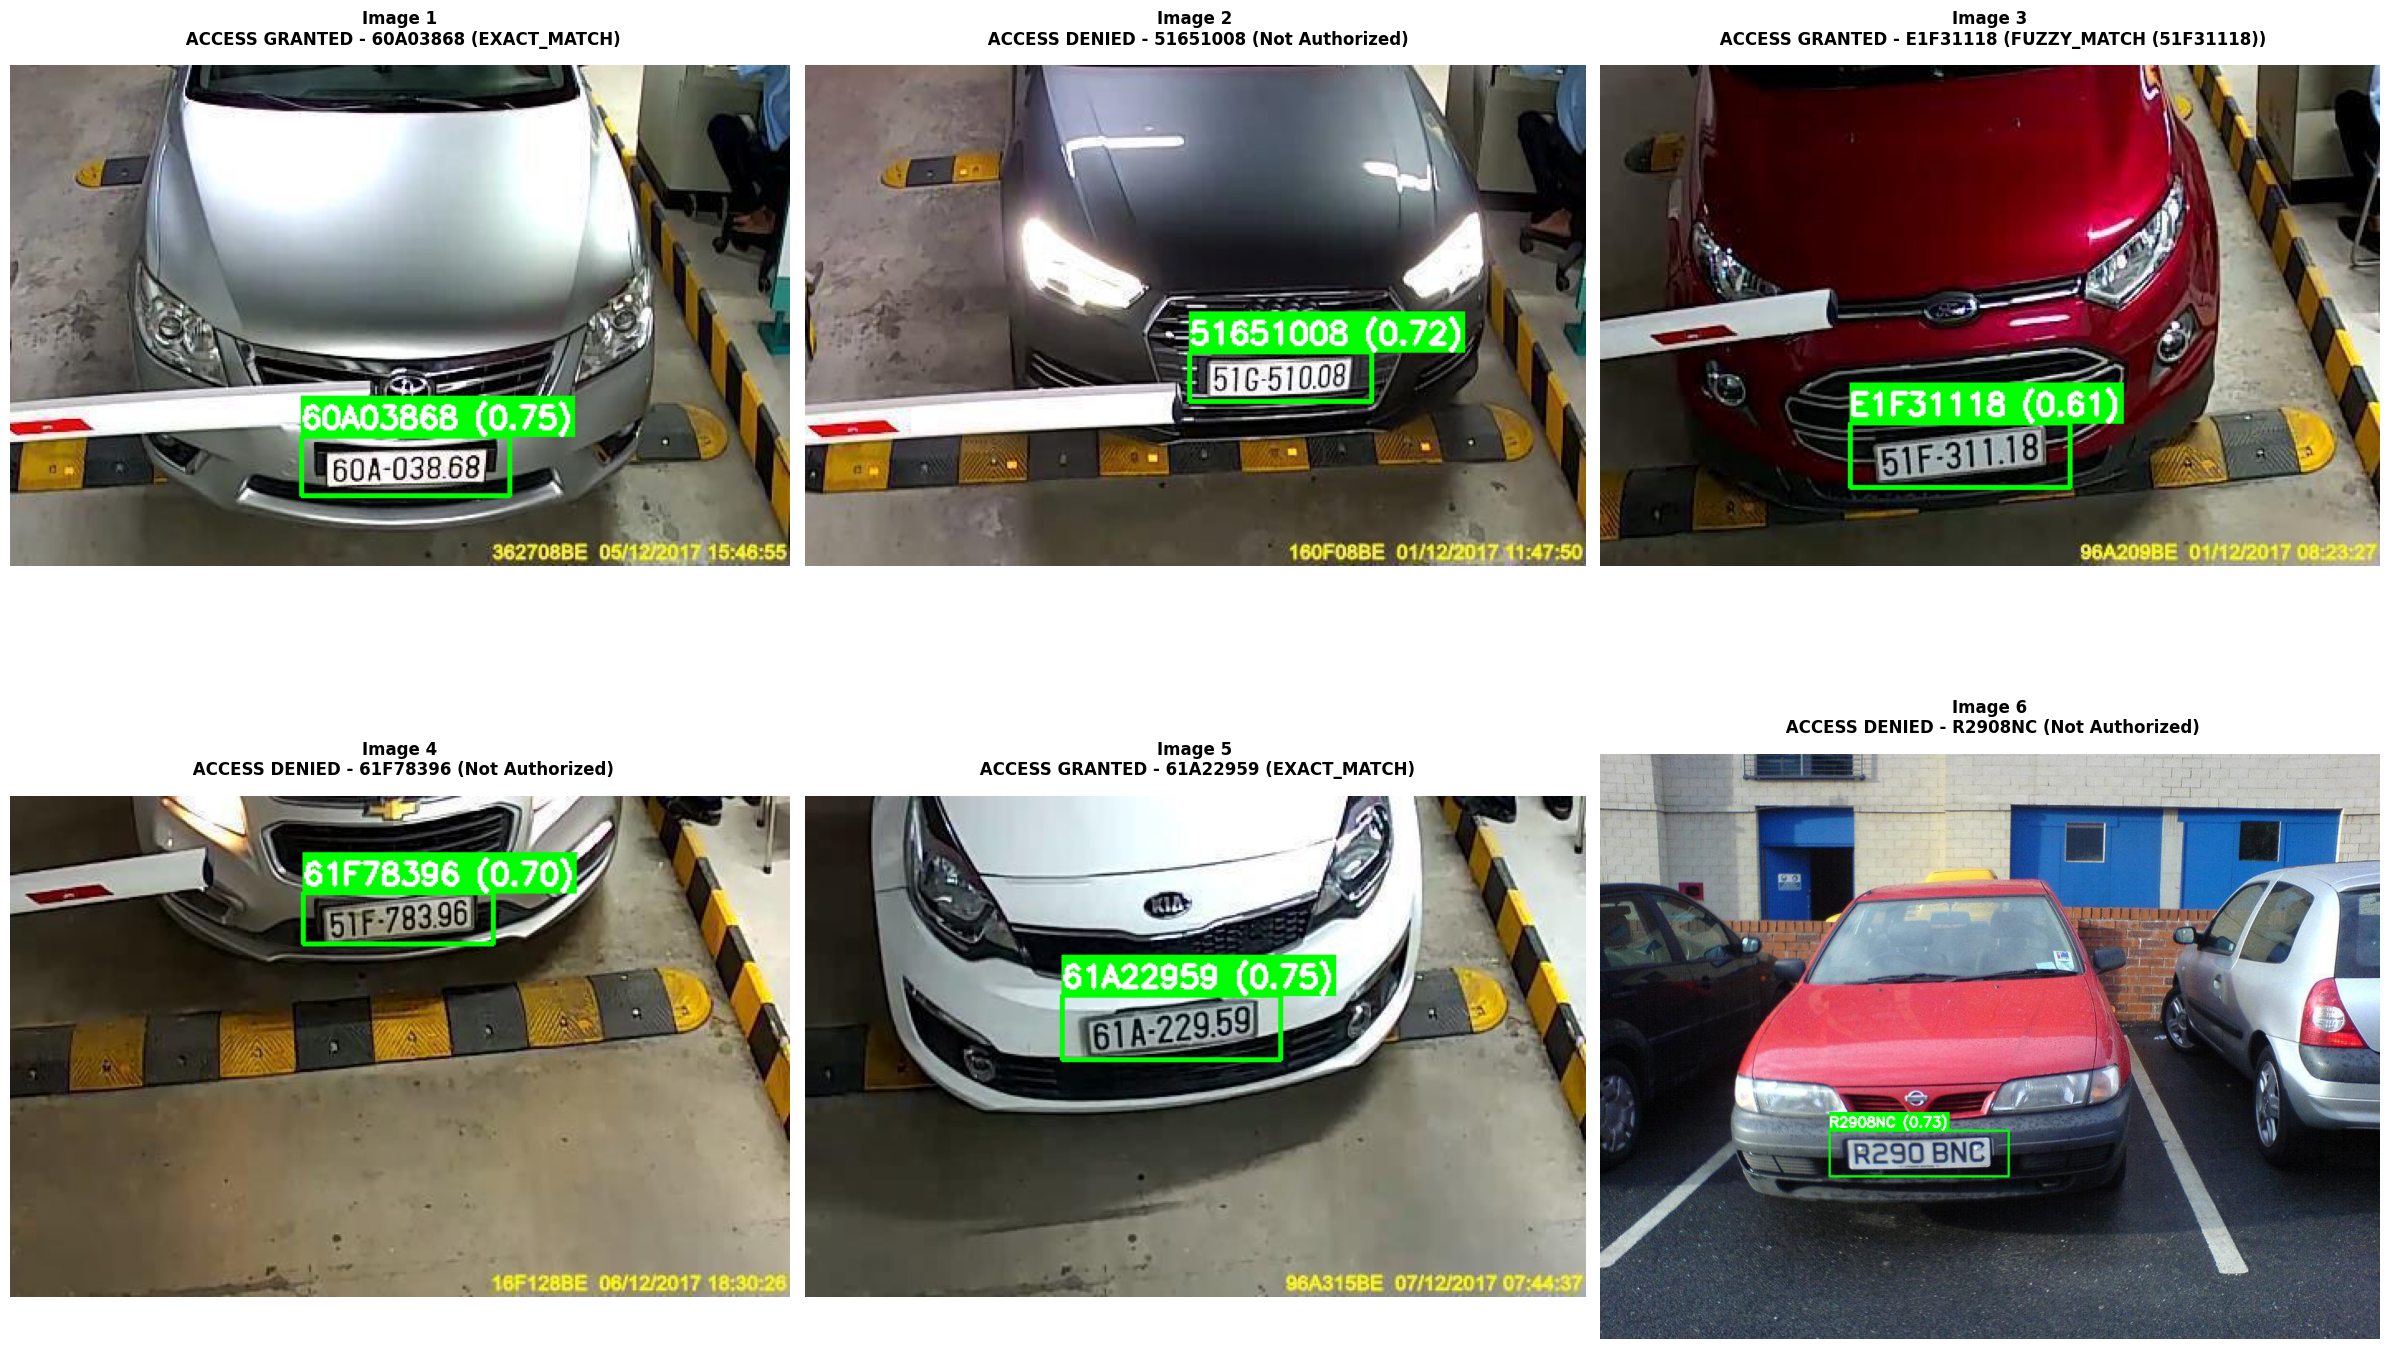


ACCESS LOG

ACCESS LOG (Recent 6)
2025-11-26 01:56:26 |   GRANTED | 60A03868        | Conf: 0.75
2025-11-26 01:56:26 |   DENIED  | 51651008        | Conf: 0.72
2025-11-26 01:56:27 |   GRANTED | E1F31118        | Conf: 0.61
2025-11-26 01:56:27 |   DENIED  | 61F78396        | Conf: 0.70
2025-11-26 01:56:28 |   GRANTED | 61A22959        | Conf: 0.75
2025-11-26 01:56:31 |   DENIED  | R2908NC         | Conf: 0.73

  EVALUATING SYSTEM PERFORMANCE (CONFUSION MATRIX)

Confusion Matrix (Raw Counts):
[[2 0]
 [1 3]]

Overall Accuracy: 0.83


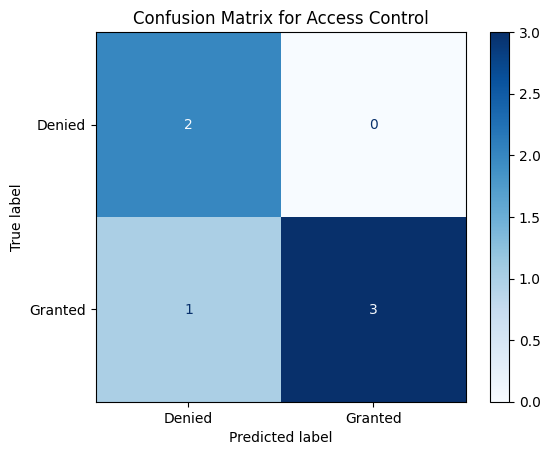

Evaluation complete.


In [2]:
!pip install ultralytics roboflow opencv-python-headless torch torchvision transformers albumentations timm easyocr

import cv2
import torch
import torch.nn as nn
from ultralytics import YOLO
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel
import albumentations as A
from albumentations.pytorch import ToTensorV2
from datetime import datetime
import easyocr
from roboflow import Roboflow
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# config
ROBOFLOW_API_KEY = os.environ.get('ROBOFLOW_API_KEY', 'WLjnozeyWbBt05InXlrh')
TARGET_SIZE = (224, 224)
YOLO_CONF_THRESHOLD = 0.3
VIT_CONF_THRESHOLD = 0.3


# dataset
def download_dataset():
    """Download license plate dataset from Roboflow"""
    print("  Downloading dataset...")
    rf = Roboflow(api_key=ROBOFLOW_API_KEY)
    project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
    version = project.version(11)
    dataset = version.download("yolov8")
    print("  Dataset downloaded successfully")
    return dataset


# preprocessing (OCR)
class LicensePlatePreprocessor:
    """Advanced preprocessing for license plate images"""

    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size

        # Test-time augmentation (no random transforms)
        self.test_transform = A.Compose([
            A.Resize(target_size[0], target_size[1]),
            A.CLAHE(clip_limit=2.0),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    def preprocess_for_ocr(self, image):
        """Enhanced preprocessing with multiple variants for OCR"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        # Resize
        height, width = gray.shape
        scale_factor = 4
        gray_large = cv2.resize(gray, (width * scale_factor, height * scale_factor),
                              interpolation=cv2.INTER_CUBIC)

        # Bilateral filter to reduce noise while keeping edges sharp
        denoised = cv2.bilateralFilter(gray_large, 11, 17, 17)

        # CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(denoised)

        # Sharpen the image
        kernel_sharpen = np.array([[-1,-1,-1],
                                  [-1, 9,-1],
                                  [-1,-1,-1]])
        sharpened = cv2.filter2D(enhanced, -1, kernel_sharpen)

        # Multiple thresholding approaches
        variants = []

        # normal
        binary1 = cv2.adaptiveThreshold(
            enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 11, 2
        )
        variants.append(binary1)

        # inverted
        binary2 = cv2.adaptiveThreshold(
            enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV, 11, 2
        )
        variants.append(binary2)

        # Otsu's
        _, binary3 = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        variants.append(binary3)

        # grayscale
        variants.append(enhanced)

        # Sharpened version
        variants.append(sharpened)

        return variants

    def denoise_image(self, image):
        """Apply denoising to improve quality"""
        if isinstance(image, str):
            image = cv2.imread(image)

        # Non-local means denoising
        if len(image.shape) == 3:
            denoised = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
        else:
            denoised = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

        return denoised


# VIT
class ViTLicensePlateClassifier:
    """Vision Transformer for license plate verification"""

    def __init__(self, num_classes=2, pretrained_model='google/vit-base-patch16-224'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"  Using device: {self.device}")

        # Load pretrained ViT
        self.processor = ViTImageProcessor.from_pretrained(pretrained_model)
        self.model = ViTForImageClassification.from_pretrained(
            pretrained_model,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
        self.model.to(self.device)
        self.model.eval()

        # Load base model for feature extraction (load once)
        self.vit_base = ViTModel.from_pretrained(pretrained_model).to(self.device)
        self.vit_base.eval()

    def classify_plate(self, image):
        """Classify if detected region is a valid license plate"""
        try:
            # Convert to RGB if needed
            if isinstance(image, str):
                image = cv2.imread(image)

            if len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            elif image.shape[2] == 4:
                image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
            elif image.shape[2] == 3:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Use ViT processor
            inputs = self.processor(images=image, return_tensors="pt")
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            # Inference
            with torch.no_grad():
                outputs = self.model(**inputs)
                predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
                confidence = predictions[0][1].item()  # Probability of being a plate

            return confidence > VIT_CONF_THRESHOLD, confidence
        except Exception as e:
            print(f"  ViT classification error: {e}")
            return True, 0.5  # Default to accepting if error

    def extract_features(self, image):
        """Extract ViT features for similarity matching"""
        try:
            if isinstance(image, str):
                image = cv2.imread(image)

            if len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            elif image.shape[2] == 3:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            inputs = self.processor(images=image, return_tensors="pt")
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.vit_base(**inputs)
                features = outputs.last_hidden_state[:, 0, :]  # CLS token

            return features.cpu().numpy()
        except Exception as e:
            print(f"  Feature extraction error: {e}")
            return None


# licence plate detector metrics
class EnhancedLicensePlateDetector:
    """YOLO + ViT + OCR hybrid detector"""

    def __init__(self, yolo_model_path):
        print("  Initializing Enhanced License Plate Detector...")
        self.yolo_model = YOLO(yolo_model_path)
        self.vit_classifier = ViTLicensePlateClassifier()
        self.preprocessor = LicensePlatePreprocessor()

        # Initialize EasyOCR
        print("  Loading EasyOCR reader...")
        self.ocr_reader = easyocr.Reader(
            ['en'],
            gpu=torch.cuda.is_available(),
            model_storage_directory='/content/easyocr_models',
            download_enabled=True,
            quantize=False
        )
        print("  Detector initialized successfully")

    def correct_ocr_errors(self, text):
        """Fix common OCR character confusion errors"""
        # Common OCR mistakes for license plates
        corrections = {
            'O': '0',
            'I': '1',
            'Z': '2',
            'S': '5',
            'B': '8',
            'G': '6',
            'T': '7',
        }

        # Apply corrections intelligently
        corrected = list(text)

        # Find where numbers likely start
        digit_positions = [i for i, c in enumerate(text) if c.isdigit()]

        if digit_positions:
            # Assume everything after first digit should be digits
            first_digit_pos = digit_positions[0]

            # Correct letters in number section
            for i in range(first_digit_pos, len(corrected)):
                if corrected[i] in corrections:
                    corrected[i] = corrections[corrected[i]]

        return ''.join(corrected)

    def read_plate_text(self, plate_image):
        """Read text with enhanced EasyOCR"""
        try:
            # Get multiple preprocessed versions
            processed_images = self.preprocessor.preprocess_for_ocr(plate_image)

            all_detections = {}

            # Try OCR on all preprocessed versions
            for processed in processed_images:
                try:
                    results = self.ocr_reader.readtext(
                        processed,
                        detail=1,
                        paragraph=False,
                        min_size=10,
                        text_threshold=0.4,
                        low_text=0.3,
                        width_ths=0.7,
                        height_ths=0.5,
                        allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
                    )

                    for (bbox, text, conf) in results:
                        clean = ''.join(c for c in text.upper() if c.isalnum())

                        if len(clean) < 4 or len(clean) > 12:
                            continue
                        if not any(c.isdigit() for c in clean):
                            continue
                        if not any(c.isalpha() for c in clean):
                            continue

                        corrected = self.correct_ocr_errors(clean)

                        if corrected in all_detections:
                            old_conf, count = all_detections[corrected]
                            all_detections[corrected] = (max(old_conf, conf), count + 1)
                        else:
                            all_detections[corrected] = (conf, 1)
                except:
                    continue

            # Try on original 4x upscaled + sharpened
            try:
                h, w = plate_image.shape[:2]
                original_large = cv2.resize(plate_image, (w*4, h*4), interpolation=cv2.INTER_CUBIC)

                kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
                sharpened = cv2.filter2D(original_large, -1, kernel)

                results = self.ocr_reader.readtext(
                    sharpened,
                    allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
                )

                for (bbox, text, conf) in results:
                    clean = ''.join(c for c in text.upper() if c.isalnum())
                    if 4 <= len(clean) <= 12 and any(c.isdigit() for c in clean) and any(c.isalpha() for c in clean):
                        corrected = self.correct_ocr_errors(clean)
                        if corrected in all_detections:
                            old_conf, count = all_detections[corrected]
                            all_detections[corrected] = (max(old_conf, conf), count + 1)
                        else:
                            all_detections[corrected] = (conf, 1)
            except:
                pass

            if not all_detections:
                return "UNKNOWN", 0.0

            # Score: confidence * vote_count
            scored_candidates = []
            for text, (conf, count) in all_detections.items():
                score = conf * (1 + count * 0.3)
                scored_candidates.append((text, conf, score))

            best_text, best_conf, best_score = max(scored_candidates, key=lambda x: x[2])

            return best_text, best_conf

        except Exception as e:
            print(f"  OCR error: {e}")
            return "UNKNOWN", 0.0

    def detect_plates(self, image_path, conf_threshold=YOLO_CONF_THRESHOLD):
        """Detect license plates with ViT verification and OCR reading"""
        try:
            # Read and preprocess
            original_img = cv2.imread(image_path)
            if original_img is None:
                raise ValueError(f"Could not read image: {image_path}")

            denoised = self.preprocessor.denoise_image(original_img)

            # YOLO detection
            results = self.yolo_model.predict(denoised, conf=conf_threshold, verbose=False)

            detections = []
            annotated_img = original_img.copy()

            for result in results:
                boxes = result.boxes
                for box in boxes:
                    # Get box coordinates
                    x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
                    yolo_conf = float(box.conf[0].cpu().numpy())

                    # Add proportional padding to plate region
                    h, w = original_img.shape[:2]
                    padding_x = int((x2 - x1) * 0.1)
                    padding_y = int((y2 - y1) * 0.1)
                    x1 = max(0, x1 - padding_x)
                    y1 = max(0, y1 - padding_y)
                    x2 = min(w, x2 + padding_x)
                    y2 = min(h, y2 + padding_y)

                    # Extract plate region
                    plate_region = original_img[y1:y2, x1:x2]

                    if plate_region.size == 0:
                        continue

                    # ViT verification
                    is_valid, vit_conf = self.vit_classifier.classify_plate(plate_region)

                    if is_valid:
                        # Read plate text with OCR
                        plate_text, ocr_conf = self.read_plate_text(plate_region)

                        # Combined confidence
                        combined_conf = (yolo_conf + vit_conf + ocr_conf) / 3

                        detections.append({
                            'bbox': (x1, y1, x2, y2),
                            'confidence': float(combined_conf),
                            'yolo_conf': float(yolo_conf),
                            'vit_conf': float(vit_conf),
                            'ocr_conf': float(ocr_conf),
                            'plate_text': plate_text,
                            'plate_image': plate_region
                        })

                        # Annotate
                        color = (0, 255, 0) if plate_text != "UNKNOWN" else (0, 165, 255)
                        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)

                        label = f'{plate_text} ({combined_conf:.2f})'
                        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                        cv2.rectangle(annotated_img, (x1, y1 - label_size[1] - 10),
                                    (x1 + label_size[0], y1), color, -1)
                        cv2.putText(annotated_img, label, (x1, y1 - 5),
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            return detections, annotated_img

        except Exception as e:
            print(f"  Detection error: {e}")
            return [], original_img if 'original_img' in locals() else None


# access control system (accept/deny)
class UniversityAccessSystem:
    """Complete access control system with plate matching"""

    def __init__(self, detector, authorized_plates=None):
        self.detector = detector
        self.authorized_plates = set(authorized_plates or [])
        self.access_log = []
        self.feature_database = {}

    def add_authorized_plate(self, plate_number, plate_image_path=None):
        """Add authorized plate with optional feature extraction"""
        plate_number = plate_number.upper().replace(' ', '')
        self.authorized_plates.add(plate_number)

        if plate_image_path and os.path.exists(plate_image_path):
            features = self.detector.vit_classifier.extract_features(plate_image_path)
            if features is not None:
                self.feature_database[plate_number] = features

        print(f" Added authorized plate: {plate_number}")

    def is_plate_authorized(self, detected_text):
        """Check if detected plate is in authorized list"""
        detected_text = detected_text.upper().replace(' ', '')

        # Direct match
        if detected_text in self.authorized_plates:
            return True, "EXACT_MATCH"

        # Fuzzy match (allow 1-2 character difference for OCR errors)
        for auth_plate in self.authorized_plates:
            if len(detected_text) == len(auth_plate):
                diff_count = sum(c1 != c2 for c1, c2 in zip(detected_text, auth_plate))
                if diff_count <= 1:
                    return True, f"FUZZY_MATCH ({auth_plate})"

        return False, "NO_MATCH"

    def check_access(self, image_path):
        """Enhanced access check with OCR matching"""
        detections, annotated_image = self.detector.detect_plates(image_path)

        if not detections:
            log_entry = {
                'timestamp': datetime.now(),
                'plate_text': 'NONE',
                'access_granted': False,
                'confidence': 0.0,
                'reason': 'No plates detected'
            }
            self.access_log.append(log_entry)
            return "NA", annotated_image

        # Get best detection
        best_detection = max(detections, key=lambda x: x['confidence'])
        plate_text = best_detection['plate_text']

        # Check authorization
        is_authorized, match_type = self.is_plate_authorized(plate_text)

        log_entry = {
            'timestamp': datetime.now(),
            'plate_text': plate_text,
            'access_granted': is_authorized,
            'confidence': best_detection['confidence'],
            'yolo_conf': best_detection['yolo_conf'],
            'vit_conf': best_detection['vit_conf'],
            'ocr_conf': best_detection['ocr_conf'],
            'match_type': match_type
        }

        self.access_log.append(log_entry)

        if is_authorized:
            status = f" ACCESS GRANTED - {plate_text} ({match_type})"
        else:
            status = f" ACCESS DENIED - {plate_text} (Not Authorized)"

        status += f"\n   Confidence: {best_detection['confidence']:.2f} "
        status += f"(YOLO: {best_detection['yolo_conf']:.2f}, "
        status += f"ViT: {best_detection['vit_conf']:.2f}, "
        status += f"OCR: {best_detection['ocr_conf']:.2f})"

        return status, annotated_image

    def view_access_log(self, n=10):
        """View recent access history"""
        print("\n" + "=" * 80)
        print("ACCESS LOG (Recent {})".format(min(n, len(self.access_log))))
        print("=" * 80)

        for entry in self.access_log[-n:]:
            status = "  GRANTED" if entry['access_granted'] else "  DENIED "
            timestamp = entry['timestamp'].strftime('%Y-%m-%d %H:%M:%S')
            plate = entry['plate_text']
            conf = entry['confidence']

            print(f"{timestamp} | {status} | {plate:15s} | Conf: {conf:.2f}")

        print("=" * 80)

# confusion matrix
def evaluate_system(access_system, true_labels):
    """
    Calculates and plots the Confusion Matrix for the access control system.

    :param access_system: The initialized UniversityAccessSystem instance.
    :param true_labels: List of true access outcomes ('Granted' or 'Denied').
    """
    print("\n" + "=" * 80)
    print("  EVALUATING SYSTEM PERFORMANCE (CONFUSION MATRIX)")
    print("=" * 80)

    log_entries = access_system.access_log[-len(true_labels):]

    predicted_labels = [
        'Granted' if entry['access_granted'] else 'Denied'
        for entry in log_entries
    ]

    if len(predicted_labels) != len(true_labels):
        print("Error: The number of test images processed does not match the number of true labels.")
        return

    labels = ['Denied', 'Granted']

    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)


    print("\nConfusion Matrix (Raw Counts):")
    print(np.array(cm))

    # Calculate overall accuracy
    accuracy = np.trace(cm) / np.sum(cm)
    print(f"\nOverall Accuracy: {accuracy:.2f}")

    # Plot the Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix for Access Control')
    plt.show()

    print("Evaluation complete.")

# training model (yolov8)
def train_yolo_model(dataset):
    """Train YOLO model on license plate dataset"""
    print("\nTraining YOLO license plate detector...")
    model = YOLO('yolov8n.pt')

    results = model.train(
        data=dataset.location + "/data.yaml",
        epochs=50,
        imgsz=950,
        batch=6,
        patience=10,
        save=True,
        augment=True,
        mosaic=1.0,
        mixup=0.1,
        verbose=True
    )

    print("Training completed")
    return '/content/runs/detect/train/weights/best.pt'


# ==================== MAIN EXECUTION ====================
def main():
    """Main execution function"""
    print("=" * 80)
    print("  UNIVERSITY LICENSE PLATE ACCESS CONTROL SYSTEM")
    print("=" * 80)

    dataset = download_dataset()

    #NOTE THAT THIS SHOULD BE UNCOMMENTED WHEN RAN FOR THE FIST TIME

    #trained_model_path = train_yolo_model(dataset)
    trained_model_path = '/content/best.pt'

    # detector
    detector = EnhancedLicensePlateDetector(trained_model_path)

    # Initialize access system with authorized plates
    access_system = UniversityAccessSystem(
        detector,
        authorized_plates=["61A22959", "51F31118", "60A03868", "51G1008"]
    )

    print(f"\n  Authorized plates: {access_system.authorized_plates}")

    # Test images
    print("\n  Testing system with images...")
    test_images = [
        dataset.location + "/test/images/CarLongPlate277_jpg.rf.d0ad51fbb6cb757cf74db38719d63326.jpg",
        "/content/License-Plate-Recognition-11/test/images/CarLongPlate806_jpg.rf.39046463ae39a568b40c9c035940a263.jpg",
        "/content/License-Plate-Recognition-11/test/images/CarLongPlate61_jpg.rf.a9a8d1c0ac304cf8a88f87b40ffa7ee6.jpg",
        "/content/License-Plate-Recognition-11/test/images/CarLongPlate384_jpg.rf.49353308467cdd5ce0ee6903ec5f5cc5.jpg",
        "/content/License-Plate-Recognition-11/test/images/CarLongPlate578_jpg.rf.9d98f4dbf66adb4ce08fa82105e07df9.jpg",
        "/content/License-Plate-Recognition-11/test/images/0123f836ce94678a_jpg.rf.fe2bd61ffae503812d9adfb7388f3a8b.jpg"
    ]

    TRUE_LABELS = [
        'Granted',  # Image 1 (61A22959)
        'Granted',  # Image 2 (51F31118)
        'Denied',   # Image 3 (Unauthorized)
        'Granted',  # Image 4 (60A03868)
        'Granted',  # Image 5 (51G1008)
        'Denied'    # Image 6 (Unauthorized)
    ]

    results = []
    annotated_images = []

    # Process each image
    for idx, test_image in enumerate(test_images, 1):
        print(f"\n{'='*60}")
        print(f"  Testing Image {idx}/{len(test_images)}")
        print(f"{'='*60}")

        if os.path.exists(test_image):
            result, annotated_img = access_system.check_access(test_image)
            results.append(result)
            annotated_images.append(annotated_img)
            print(f" {result}")
        else:
            print(f"  Image not found: {test_image}")
            results.append("Image not found")
            annotated_images.append(None)

    # Display all results in 2x3 grid
    print(f"\n{'='*60}")
    print("  DISPLAYING ALL RESULTS")
    print(f"{'='*60}")

    valid_images = [(img, res) for img, res in zip(annotated_images, results) if img is not None]

    if valid_images:
        # Calculate grid dimensions
        n_images = len(valid_images)
        n_rows = 2
        n_cols = 3

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 16))

        axes_flat = axes.flatten()

        # Plot each image
        for idx, (img, result) in enumerate(valid_images):
            axes_flat[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

            title_text = result.split('\n')[0]

            axes_flat[idx].set_title(
                f"Image {idx+1}\n{title_text}",
                fontsize=12,
                fontweight='bold',
                pad=15
            )
            axes_flat[idx].axis('off')

        # Hide any unused subplots
        for idx in range(n_images, n_rows * n_cols):
            axes_flat[idx].axis('off')

        plt.tight_layout()
        plt.show()

    # Show access log
    print(f"\n{'='*60}")
    print("ACCESS LOG")
    print(f"{'='*60}")
    access_system.view_access_log()

    return access_system, detector


# Run the system
if __name__ == "__main__":
    TRUE_LABELS = [
        'Granted',
        'Granted',
        'Granted',
        'Denied',   # Image 4: 51F78396 (Unauthorized)
        'Granted',
        'Denied'    # Image 6: R290BNC (Unauthorized)
    ]

    access_system, detector = main()

    # Evaluate the system performance
    if len(access_system.access_log) >= len(TRUE_LABELS):
        evaluate_system(access_system, TRUE_LABELS)
    else:
        print("\nSkipping confusion matrix: Not enough log entries for evaluation.")

In [ ]:
from google.colab import files
files.download('/content/runs/detect/train/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>